#**Frameworks de Deep Learning - Lista 01**
- Essa lista tem por objetivo avaliar o uso do Keras em um problema de predição de série temporal.
- 90% do notebook está pronto, será pedido para que complete algumas poucas células


In [1]:
!pip install mlflow --quiet
!pip3 install dagshub --upgrade --quiet
!pip3 install keras --quiet
!pip3 install ann_visualizer --quiet
!pip install graphviz --quiet
!pip install h5py --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 65.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Clonando o repositório com os dados do problema

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%%time
!rm -r datasets
!git clone https://github.com/renansantosmendes/datasets.git

rm: cannot remove 'datasets': No such file or directory
Cloning into 'datasets'...
remote: Enumerating objects: 42255, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 42255 (delta 8), reused 21 (delta 8), pack-reused 42234
Receiving objects: 100% (42255/42255), 957.86 MiB | 32.67 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Updating files: 100% (84675/84675), done.
CPU times: user 671 ms, sys: 71.4 ms, total: 742 ms
Wall time: 57.6 s


## Fazendo os imports das libs necessárias

In [4]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow import keras

import numpy as np
import tensorflow as tf
import random as python_random

In [6]:
import os
import tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, Dropout
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.regularizers import l1, l2

import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Lendo os dados e armazenando em uma lista

In [7]:
%%time
root = './datasets/timeserie_covid'
files = os.listdir('./datasets/timeserie_covid')
files.sort()
data_list = [pd.read_csv(os.path.join(root, file_name), sep=';') for file_name in files]

CPU times: user 7.93 s, sys: 1.25 s, total: 9.17 s
Wall time: 9.25 s


## Concatenando os dados do arquivo

In [8]:
data = pd.concat(data_list[:], axis=0)
data.head()

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos,interior/metropolitana
0,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-25,9,210147125.0,0.0,0,0,0,0.0,0.0,NaN
1,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-26,9,210147125.0,1.0,1,0,0,1.0,0.0,NaN
2,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-27,9,210147125.0,1.0,0,0,0,1.0,0.0,NaN
3,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-28,9,210147125.0,1.0,0,0,0,0.0,1.0,NaN
4,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-29,9,210147125.0,2.0,1,0,0,1.0,1.0,NaN


## Convertendo a coluna de data de string para date

In [9]:
from datetime import datetime
def convert_date(str_date):
  return datetime.strptime(str_date, '%Y-%m-%d').date()

## Dando uma olhada no dataset

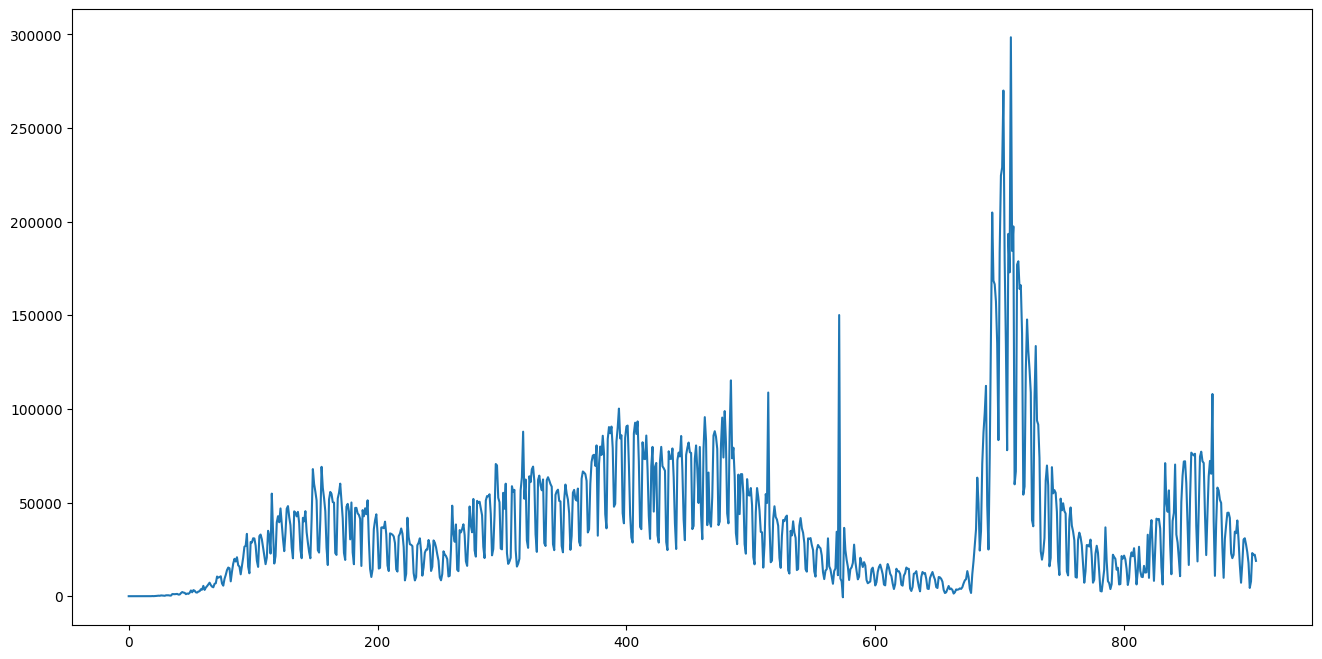

In [10]:
plt.figure(figsize=(16,8))
plt.plot(data[data['regiao'] == 'Brasil']['casosNovos'].values)
plt.show()

## Processando o dado

In [11]:
dataframe = data[data['regiao'] == 'Brasil']['casosNovos'] # Separando a variaveç casos novos para a Região = Brasil
dataset = dataframe.values
dataset

array([     0,      1,      0,      0,      1,      0,      0,      0,
            1,      4,      6,      6,      6,      0,      9,     18,
           25,     21,     23,     79,     34,     57,    137,    193,
          283,    224,    418,    345,    310,    232,    482,    502,
          486,    353,    323,   1138,   1117,   1076,   1146,   1222,
          852,    926,   1661,   2210,   1930,   1781,   1089,   1442,
         1261,   1832,   3058,   2105,   3257,   2917,   2055,   1927,
         2498,   2678,   3735,   3503,   5514,   3379,   4613,   5385,
         6276,   7218,   5919,   5097,   4751,   6633,   6935,  10503,
         9888,  10222,  10611,   6760,   5632,   9258,  11385,  13944,
        15305,  14919,   7938,  13140,  17408,  19951,  18508,  20803,
        16508,  15813,  11687,  16324,  20599,  26417,  26928,  33274,
        15760,  12247,  28936,  28633,  30925,  30830,  27075,  18912,
        15654,  32091,  32913,  30412,  25982,  21704,  17110,  20647,
      

In [12]:
dataframe = data[data['regiao'] == 'Brasil']['casosNovos']
dataset = dataframe.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1)) # Fazendo a Padronização dos dados pelo método MinMaxScaler
dataset = scaler.fit_transform([[i] for i in dataset])
dataset

array([[0.00191651],
       [0.00191985],
       [0.00191651],
       [0.00191651],
       [0.00191985],
       [0.00191651],
       [0.00191651],
       [0.00191651],
       [0.00191985],
       [0.00192989],
       [0.00193658],
       [0.00193658],
       [0.00193658],
       [0.00191651],
       [0.00194661],
       [0.00197671],
       [0.00200013],
       [0.00198675],
       [0.00199344],
       [0.00218074],
       [0.00203023],
       [0.00210716],
       [0.00237473],
       [0.00256204],
       [0.00286306],
       [0.00266572],
       [0.00331459],
       [0.00307043],
       [0.00295336],
       [0.00269248],
       [0.00352865],
       [0.00359555],
       [0.00354203],
       [0.00309719],
       [0.00299685],
       [0.00572277],
       [0.00565253],
       [0.0055154 ],
       [0.00574953],
       [0.00600373],
       [0.00476619],
       [0.0050137 ],
       [0.00747205],
       [0.00930828],
       [0.00837177],
       [0.00787341],
       [0.00555888],
       [0.006

## Separando o dado em treino e teste

In [13]:
train_size = int(len(dataset) * 0.67) # Separando 67% dos dados do dataset para treino
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:] # Separando os dados do dataset com base nas proporções de treino e teste
print(f'Dados de treino: {train_size} --- 67% da base de dados \nDados de teste: {test_size} --- 33% da base de dados')

Dados de treino: 607 --- 67% da base de dados 
Dados de teste: 300 --- 33% da base de dados


# Criando funções utilitárias

In [14]:
def create_dataset(dataset, look_back=1): # função para criar o deslocamento da série temporal
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

def reset_seeds():
   os.environ['PYTHONHASHSEED']=str(42)
   tf.random.set_seed(42)
   np.random.seed(42)
   random.seed(42)

## Preparando o dado

print(f'Dados de treino: \n\n{X_train}')

In [15]:
look_back = 15 # voltando uma janela de 15 dias no dataset
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
print(f'Dados de treino: \n\n{X_train}')

Dados de treino: 

[[[0.00191651 0.00191985 0.00191651 ... 0.00193658 0.00191651 0.00194661]]

 [[0.00191985 0.00191651 0.00191651 ... 0.00191651 0.00194661 0.00197671]]

 [[0.00191651 0.00191651 0.00191985 ... 0.00194661 0.00197671 0.00200013]]

 ...

 [[0.07057639 0.06176312 0.05406364 ... 0.02110836 0.0268211  0.04529385]]

 [[0.06176312 0.05406364 0.06269629 ... 0.0268211  0.04529385 0.05412384]]

 [[0.05406364 0.06269629 0.05694007 ... 0.04529385 0.05412384 0.05828464]]]


In [16]:
print(f'Dados de teste: \n\n{X_test}')

Dados de teste: 

[[[0.02266699 0.0213057  0.04681568 ... 0.04647118 0.04160465 0.02236931]]

 [[0.0213057  0.04681568 0.05939173 ... 0.04160465 0.02236931 0.0207739 ]]

 [[0.04681568 0.05939173 0.0529833  ... 0.02236931 0.0207739  0.03853422]]

 ...

 [[0.07571384 0.11718805 0.11440861 ... 0.06120456 0.01673016 0.02852021]]

 [[0.11718805 0.11440861 0.13715253 ... 0.01673016 0.02852021 0.07897826]]

 [[0.11440861 0.13715253 0.10217706 ... 0.02852021 0.07897826 0.07525562]]]


# Inicializando o MLflow e DagsHub

In [17]:
import pickle
import dagshub
import mlflow
from mlflow import MlflowClient

In [18]:
mlflow.tensorflow.autolog(log_models=True,
                       log_input_examples=True,
                       log_model_signatures=True)

In [19]:
#Salvando o modelo do standardScaler em um diretório temporário
tmp_dir = 'tmp'

if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

pickle.dump(scaler,
            open(os.path.join(tmp_dir,
                              'scaler.pkl'), 'wb'))

In [ ]:
# Criando um repositório no DagsHub
MLFLOW_TRACKING_URI='#################'
MLFLOW_TRACKING_USERNAME='#################'
MLFLOW_TRACKING_PASSWORD='#################'

os.environ['MLFLOW_TRACKING_USERNAME'] = MLFLOW_TRACKING_USERNAME
os.environ['MLFLOW_TRACKING_PASSWORD'] = MLFLOW_TRACKING_PASSWORD

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

# **Questão 01 - 30pts - Criando o modelo**
Esta é uma das células para completar, crie um modelo e adicione algumas camadas para treiná-lo.

**Dicas importantes**
- Podem escolher qualquer tipo de camada
- Para aqueles que optarem por camadas recorrentes, lembrem de adicionar o parametro ```return_sequences=True```
- Lembrem-se de que o problema agora é uma predição e não uma classificação, logo prestem atenção na camada de saída do modelo


In [21]:
### Função para visualização do histotry de treinamento
def plot_convergence(hist: tensorflow.keras.callbacks.History,
                     metric_name:str) -> None:
  figure = plt.gcf()
  figure.set_size_inches((15, 5))
  figure.patch.set_facecolor('darkgrey')

  ax = plt.axes()
  ax.set_facecolor("darkgrey")

  plt.xlabel('Epoch', fontsize=14)
  plt.xticks(fontsize=14)
  plt.ylabel(metric_name.title(), fontsize=14)
  plt.yticks(fontsize=14)

  plt.plot(range(1, len(hist.history[metric_name.lower()]) + 1),
           hist.history[metric_name.lower()], marker='o', linewidth=3,
           markersize=12)
  plt.plot(range(1, len(hist.history[f'val_{metric_name.lower()}']) + 1),
           hist.history[f'val_{metric_name.lower()}'], marker='X', linewidth=3,
           markersize=12)
  plt.legend([metric_name.title(), f'Validation {metric_name.title()}'],
             fontsize=14)
  plt.show()


In [22]:
def grafico_animado(history,funcao1,funcao2="", mode='video'):
  from itertools import count
  import matplotlib.pyplot as plt
  from matplotlib.animation import FuncAnimation
  from matplotlib import animation
  from matplotlib import animation, rc
  from IPython.display import HTML, Image # For GIF
  import numpy as np
  import PIL
  from PIL import Image
  import matplotlib.image as mpimg
  %matplotlib inline

  figure = plt.gcf()
  figure.set_size_inches((15, 5))
  figure.patch.set_facecolor('darkgrey')


  epochs= np.arange(0,len(history[str(funcao1)]))
  # print(f'Epocas:{epochs}')

  x_min = min(epochs)+1
  x_max = max(epochs)+1

  if funcao2 == "":
    y_min = min(history[str(funcao1)])
    y_max = max(history[str(funcao1)])


  else:
    y_minf1 = min(history[str(funcao1)])
    y_maxf1 = max(history[str(funcao1)])
    y_minf2 = min(history[str(funcao2)])
    y_maxf2 = max(history[str(funcao2)])
    y_min = min(y_minf1, y_minf2)
    y_max = max(y_maxf1, y_maxf2)


  fig, ax = plt.subplots(figsize =(15,5))
  ax.set_xlim(( x_min, x_max))
  ax.set_ylim((y_min, y_max))
  ax.set_xlabel('Epoch')
  ax.set_ylabel(str(funcao1))

  if funcao2 == "":
    line1, = ax.plot([],[] ,'b', lw=2)
    #line1, = ax.plot([],[] ,'b', lw=2, label='{}'.format(str(funcao1)))
    #plt.legend()

  else:
    line1, = ax.plot([],[] ,'b', lw=2, label='{}'.format(str(funcao1)))
    line2, = ax.plot([],[] ,'r', lw=2, label='{}'.format(str(funcao2)))
    plt.legend()

  txt_title = ax.set_title('')

  contador = count(0, 1)
  x = []
  y = []
  w = []
  z = []

  def update(i):
    i= next(contador)
    # print(f'contador: {i}')

    if i > len(epochs)-1:
      if funcao2 == "":
        return (line1, )

      else:
        return (line1,line2, )

    else:
      if funcao2 =="":
        b = history[str(funcao1)]
        x.append(i)
        y.append(b[i])

        line1.set_data(x, y)

      else:
        b = history[str(funcao1)]
        c = history[str(funcao2)]
        x.append(i)
        y.append(b[i])
        w.append(i)
        z.append(c[i])

        line1.set_data(x, y)
        line2.set_data(w, z)

        # print(f'Epoca: {i}')
        txt_title.set_text(f'Epoch: {i+1}')

      if funcao2 == "":
        return (line1, )

      else:
        return (line1,line2, )


      #txt_title.set_text(f'Epoch: {i+1}')



  frames_ = len(epochs)
  intervalo = 200


  if mode == 'video':
    anim = FuncAnimation(fig, update, frames= frames_, interval= intervalo, repeat=False, blit=True)
    file_name = str('/content/' + funcao1 + '.mp4' )
    from IPython.display import HTML
    return HTML(anim.to_html5_video())

  elif mode == 'gif':
    anim = FuncAnimation(fig, update, frames= frames_, interval= intervalo, repeat=True, blit=True)
    file_name = str('/content/' + funcao1 + '.gif' )
    anim.save(file_name, writer='pillow', fps = frames_)
    from IPython.core.interactiveshell import InteractiveShell
    InteractiveShell.ast_node_interactivity = "all"
    from IPython.display import Image
    return Image(file_name)


In [26]:
l, c = data.shape
c= c-1

In [27]:
print(l,c)

4923112 16


In [28]:
X_train[:].shape

(591, 1, 15)

In [29]:
x= X_train.shape
c= x[1:3]
c

(1, 15)

In [30]:
from keras.models import Sequential
from keras.layers import InputLayer, SimpleRNN, Dense



---



---



Modelo com camadas Densas - **Dense**

In [ ]:
reset_seeds()
model_Dense = Sequential()
model_Dense.add(InputLayer(input_shape=(c)))
model_Dense.add(Dense(units= 150, activation= 'relu'))
model_Dense.add(Dense(units= 150, activation= 'relu'))
model_Dense.add(Dense(units= 150, activation= 'relu'))
model_Dense.add(Dense(units= 150, activation= 'relu'))
model_Dense.add(Dense(units= 150, activation= 'relu'))
model_Dense.add(Dense(units= 150, activation= 'relu'))
model_Dense.add(Dense(units= 150, activation= 'relu'))
# model_Dense.add(Dense(units= 150, activation= 'relu'))
# model_Dense.add(Dense(units= 150, activation= 'relu'))
# model_Dense.add(Dense(units= 150, activation= 'relu'))
# model_Dense.add(Dense(units= 150, activation= 'relu'))
# model_Dense.add(Dense(units= 150, activation= 'relu'))
# model_Dense.add(Dense(units= 150, activation= 'relu'))
model_Dense.add(Dense(units= 1, activation= 'linear'))

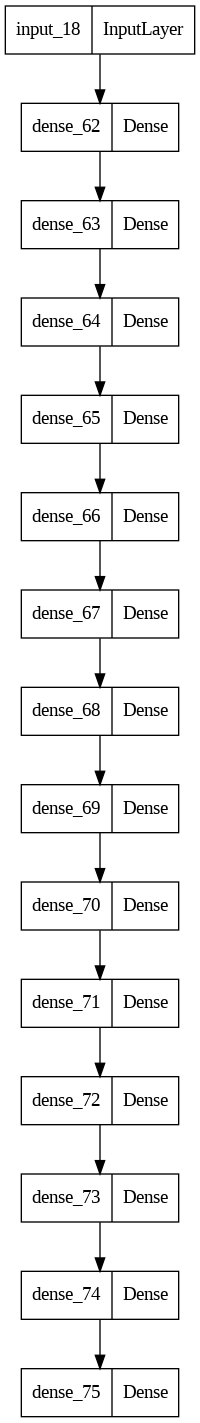

In [ ]:
tensorflow.keras.utils.plot_model(model_Dense)

In [ ]:
model_Dense.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_62 (Dense)            (None, 1, 150)            2400      
                                                                 
 dense_63 (Dense)            (None, 1, 150)            22650     
                                                                 
 dense_64 (Dense)            (None, 1, 150)            22650     
                                                                 
 dense_65 (Dense)            (None, 1, 150)            22650     
                                                                 
 dense_66 (Dense)            (None, 1, 150)            22650     
                                                                 
 dense_67 (Dense)            (None, 1, 150)            22650     
                                                                 
 dense_68 (Dense)            (None, 1, 150)          



---


---



Modelo com camadas Recorrentes - **SimpleRNN**

In [ ]:
from keras.layers import SimpleRNN

reset_seeds()
model_SimpleRNN = Sequential()
model_SimpleRNN.add(InputLayer(input_shape=(c)))
model_SimpleRNN.add(SimpleRNN(units=150, activation='relu', return_sequences=True))
model_SimpleRNN.add(Dropout(0.2))
model_SimpleRNN.add(SimpleRNN(units=150, activation='relu', return_sequences=True))
model_SimpleRNN.add(Dropout(0.2))
model_SimpleRNN.add(SimpleRNN(units=150, activation='relu', return_sequences=True))
model_SimpleRNN.add(Dropout(0.2))
model_SimpleRNN.add(SimpleRNN(units=150, activation='relu', return_sequences=True)
model_SimpleRNN.add(Dropout(0.2)))
model_SimpleRNN.add(SimpleRNN(units=150, activation='relu', return_sequences=True))
model_SimpleRNN.add(Dropout(0.2))
# model_SimpleRNN.add(SimpleRNN(units=150, activation='relu', return_sequences=True))
# model_SimpleRNN.add(SimpleRNN(units=150, activation='relu', return_sequences=True))
# model_SimpleRNN.add(SimpleRNN(units=150, activation='relu', return_sequences=True))
# model_SimpleRNN.add(SimpleRNN(units=150, activation='relu', return_sequences=True))
# model_SimpleRNN.add(SimpleRNN(units=150, activation='relu', return_sequences=True))
# model_SimpleRNN.add(SimpleRNN(units=150, activation='relu', return_sequences=True))
# model_SimpleRNN.add(SimpleRNN(units=150, activation='relu', return_sequences=True))
# model_SimpleRNN.add(SimpleRNN(units=150, activation='relu', return_sequences=True))
# model_SimpleRNN.add(SimpleRNN(units=150, activation='relu', return_sequences=True))
model_SimpleRNN.add(SimpleRNN(units=1, activation='linear'))

SyntaxError: ignored

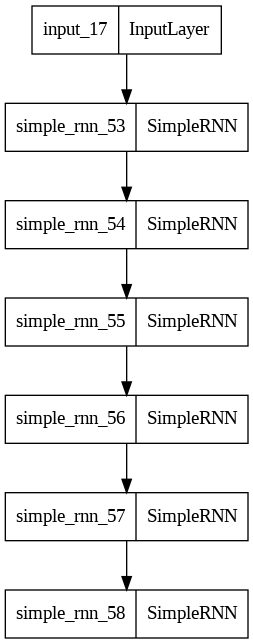

In [ ]:
tensorflow.keras.utils.plot_model(model_SimpleRNN)

In [ ]:
model_SimpleRNN.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_53 (SimpleRNN)   (None, 1, 150)            24900     
                                                                 
 simple_rnn_54 (SimpleRNN)   (None, 1, 150)            45150     
                                                                 
 simple_rnn_55 (SimpleRNN)   (None, 1, 150)            45150     
                                                                 
 simple_rnn_56 (SimpleRNN)   (None, 1, 150)            45150     
                                                                 
 simple_rnn_57 (SimpleRNN)   (None, 1, 150)            45150     
                                                                 
 simple_rnn_58 (SimpleRNN)   (None, 1, 1)              152       
                                                                 
Total params: 205652 (803.33 KB)
Trainable params: 20

In [ ]:
# from ann_visualizer.visualize import ann_viz
# import graphviz
# from IPython.display import display
# from PIL import Image
# from IPython.display import display

# ann_viz(model, title="Artificial Neural network - Model Visualization")
# # Converter o arquivo .gv em imagem
# gv_path = "/content/network.gv"
# !dot -Tpng {gv_path} -o ann_viz_output.png
# gv_img = Image.open("ann_viz_output.png")
# display(gv_img)



---



---



# **Questão 02 - 10pts - Compilando o modelo**
Compile o modelo criado anteriormente e use um otimizador com uma taxa de aprendizado de 0.001

Dicas:
- use como função de perda ```loss='mean_squared_error'```
- importe o otimizador e crie um objeto
- use qualquer otimizador



---



---



Compilação Modelo com camadas Densas - **Dense**




In [ ]:
model_Dense.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics = ['mean_squared_error'])



---



---



Compilação Modelo com camadas Recorrentes - **SimpleRNN**

In [ ]:
optmizer=SGD(learnung)

In [ ]:
#Compilação Modelo com camadas recorentes SimpleRNN
model_SimpleRNN.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics = ['mean_squared_error'])



---



---



# **Questão 03 - 10pts - Treinando o modelo**
Treine o modelo criado anteriormente utilizando os dados de treino, com 100 épocas, batches de 128 exemplos e 20% como tamanho dos dados de validação

Dicas:
- use os parâmetros do método que treina os modelos no Keras



---



---



Treinamento Modelo com camadas Densas - **Dense**

In [ ]:
%%time
with mlflow.start_run(run_name='Model_DenseLayer') as run:
  history_Dense = model_Dense.fit(X_train,
                 y_train,
                 epochs=50,
                 validation_split= 0.2)

2023/09/23 21:14:43 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}


Epoch 1/50
 1/15 [=>............................] - ETA: 26s - loss: 0.0223 - mean_squared_error: 0.0223

15/15 [==============================] - 3s 47ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 2/50
15/15 [==============================] - 0s 9ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 3/50
15/15 [==============================] - 0s 9ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0057 - val_mean_squared_error: 0.0057
Epoch 4/50
15/15 [==============================] - 0s 8ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 5/50
15/15 [==============================] - 0s 9ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0052 - val_mean_squared_error: 0.0052
Epoch 6/50
15/15 [==============================] - 0s 8ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 7/50
15/15 [==============================] 

2023/09/23 21:15:09 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.4.14+cuda11.cudnn86) contains a local version label (+cuda11.cudnn86). MLflow logged a pip requirement for this package as 'jaxlib==0.4.14' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


CPU times: user 14 s, sys: 299 ms, total: 14.3 s
Wall time: 40.9 s


In [ ]:
k = []
for kk, v in history_Dense.history.items():
  k.append(kk)
print(k)

['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error']


In [ ]:
print(history_Dense.history['loss'])
print(history_Dense.history['val_loss'])
print(history_Dense.history['val_mean_squared_error'])
print(history_Dense.epoch)

[0.00753068970516324, 0.007284725550562143, 0.007267279084771872, 0.007313175592571497, 0.007467878051102161, 0.007261919789016247, 0.007317534647881985, 0.007276709191501141, 0.00738157145678997, 0.007304141763597727, 0.007329469546675682, 0.007322479970753193, 0.007433134131133556, 0.007253809366375208, 0.007282251492142677, 0.007282461505383253, 0.007332606706768274, 0.007286294363439083, 0.007313786074519157, 0.007410592399537563, 0.007299819029867649, 0.007277627941220999, 0.007300834637135267, 0.007320512551814318, 0.007284265942871571, 0.007327903527766466, 0.007266463246196508, 0.007271655835211277, 0.00726237753406167, 0.0072921630926430225, 0.007293532602488995, 0.0072844666428864, 0.0073653035797178745, 0.007271656766533852, 0.007317877374589443, 0.0072762928903102875, 0.007303454913198948, 0.007305915933102369, 0.007300401106476784, 0.007262153085321188, 0.007273469120264053, 0.007328919135034084, 0.0072714402340352535, 0.007301197852939367, 0.007284368388354778, 0.00729524

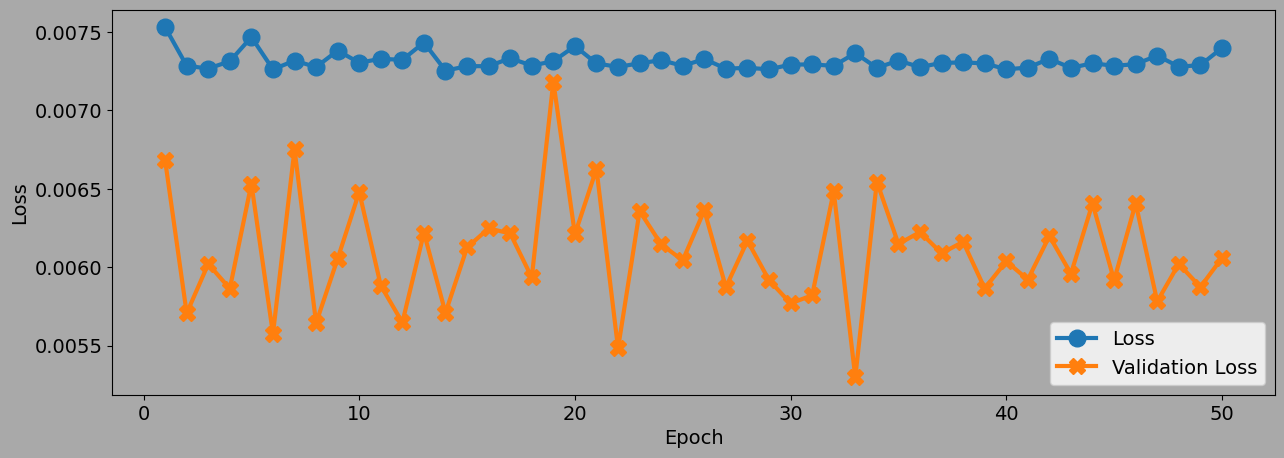

In [ ]:
plot_convergence(history_Dense, 'loss')

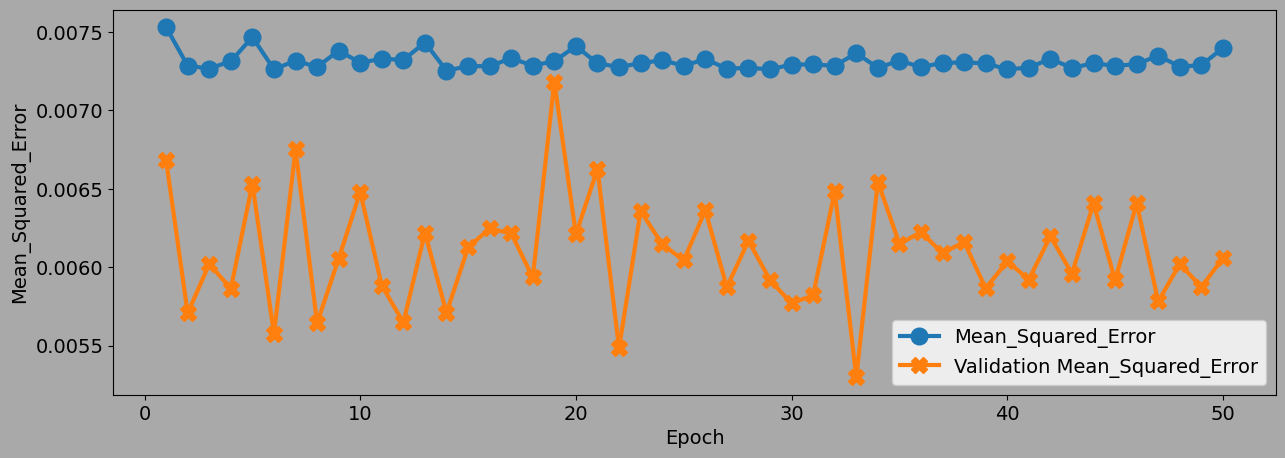

In [ ]:
plot_convergence(history_Dense, "mean_squared_error")

In [ ]:
history_D = history_Dense.history

<Figure size 1500x500 with 0 Axes>

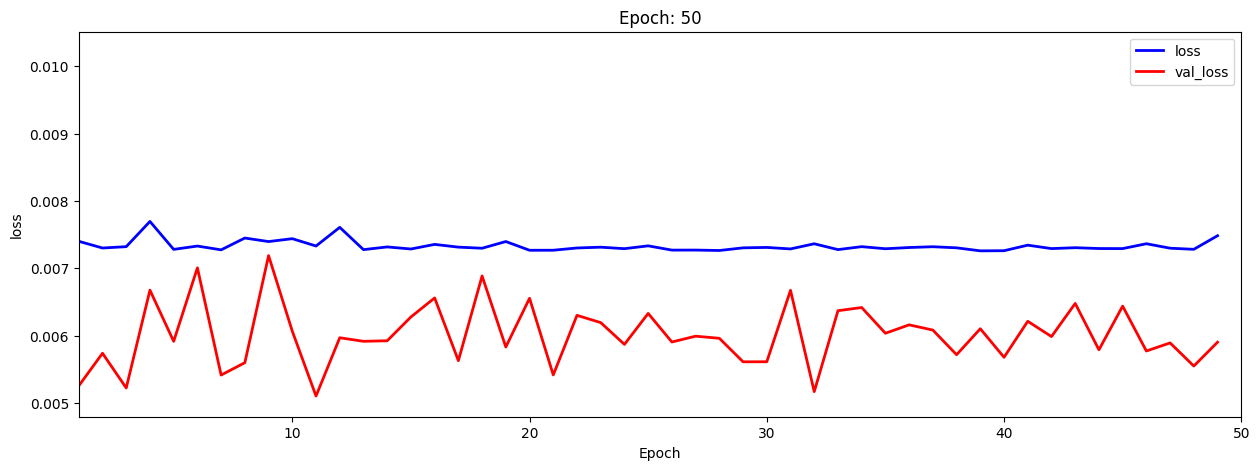

In [ ]:
grafico_animado(history_D,funcao1= 'loss',funcao2="val_loss", mode='video')

<Figure size 1500x500 with 0 Axes>

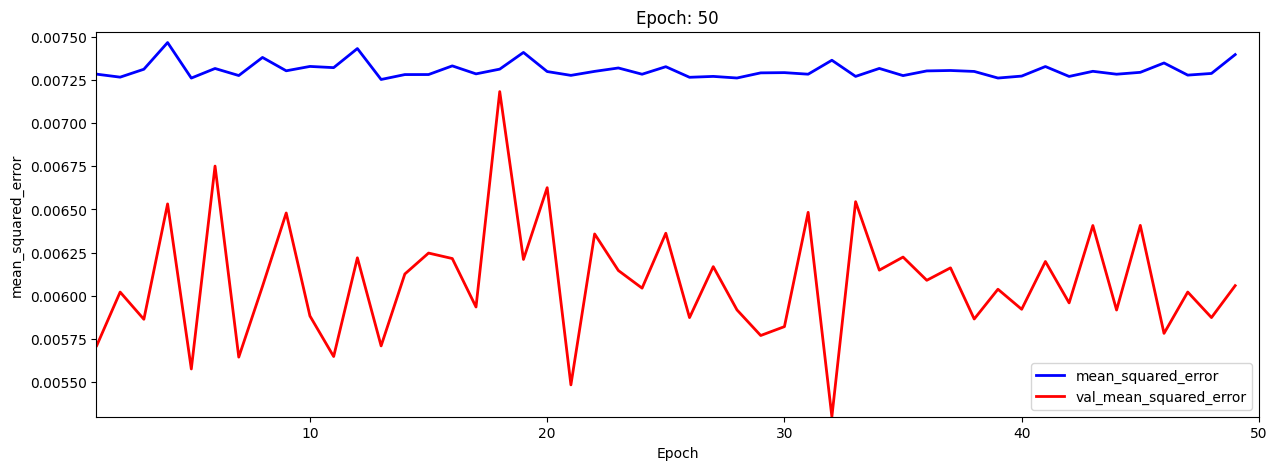

In [ ]:
grafico_animado(history_D,funcao1= 'mean_squared_error',funcao2='val_mean_squared_error', mode='video')



---



---



Treinamento Modelo com camadas Recorrentes - **SimpleRNN**

In [ ]:
with mlflow.start_run(run_name='Model_SimpleRNN') as run:
  history_SimpleRNN = model_SimpleRNN.fit(X_train,
                 y_train,
                 epochs=100,
                 validation_split= 0.2)

2023/09/23 22:32:47 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}


Epoch 1/100
 6/15 [===========>..................] - ETA: 0s - loss: 0.0112 - mean_squared_error: 0.0112  

15/15 [==============================] - 7s 82ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - val_loss: 0.0052 - val_mean_squared_error: 0.0052
Epoch 2/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 3/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 4/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 5/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 6/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0057 - val_mean_squared_error: 0.0057
Epoch 7/100
15/15 [=====================

2023/09/23 22:33:59 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.4.14+cuda11.cudnn86) contains a local version label (+cuda11.cudnn86). MLflow logged a pip requirement for this package as 'jaxlib==0.4.14' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


In [ ]:
print(history_SimpleRNN.history['loss'])
print(history_SimpleRNN.history['val_loss'])
print(history_SimpleRNN.history['val_mean_squared_error'])
print(history_SimpleRNN.epoch)

[0.0075203184969723225, 0.007292000111192465, 0.00726969912648201, 0.007324100937694311, 0.007491761352866888, 0.007253502961248159, 0.007293570786714554, 0.007263783365488052, 0.007383172400295734, 0.007321367040276527, 0.0073433006182312965, 0.007324802689254284, 0.007432722486555576, 0.0072538163512945175, 0.007283328101038933, 0.0072800409980118275, 0.007328326348215342, 0.007280442398041487, 0.007324185222387314, 0.007326479069888592, 0.0072850934229791164, 0.007275744341313839, 0.00730137201026082, 0.00728650251403451, 0.007269345223903656, 0.007302870973944664, 0.007257917895913124, 0.007269024848937988, 0.007260922342538834, 0.0072820791974663734, 0.007274235598742962, 0.00727899419143796, 0.007344357203692198, 0.007267761044204235, 0.007299925200641155, 0.0072715505957603455, 0.007287901826202869, 0.007289379835128784, 0.007278094068169594, 0.007261967286467552, 0.007272030226886272, 0.007311335764825344, 0.00726445484906435, 0.007291825953871012, 0.007272262591868639, 0.00728

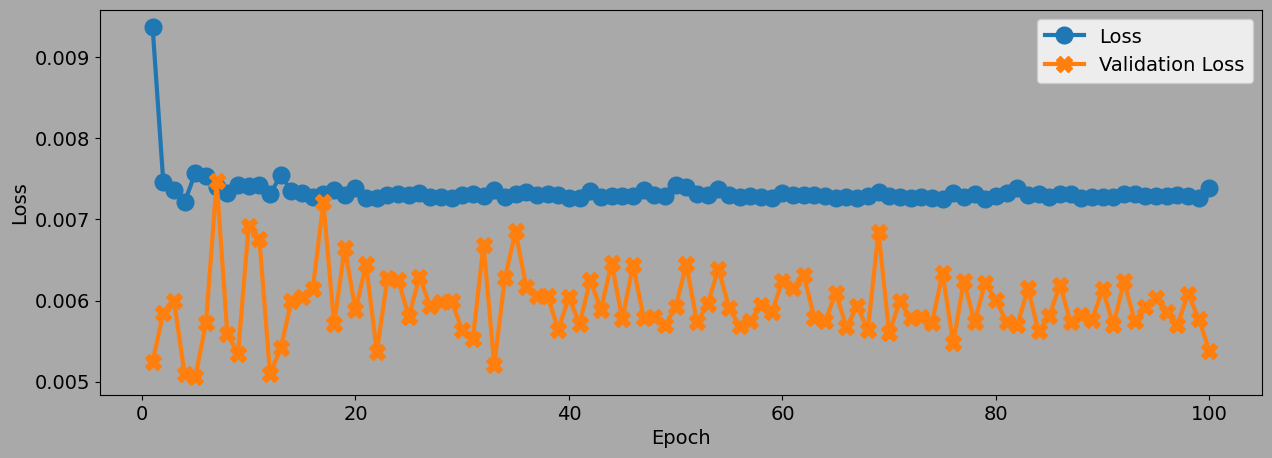

In [ ]:
plot_convergence(history_SimpleRNN, 'loss')

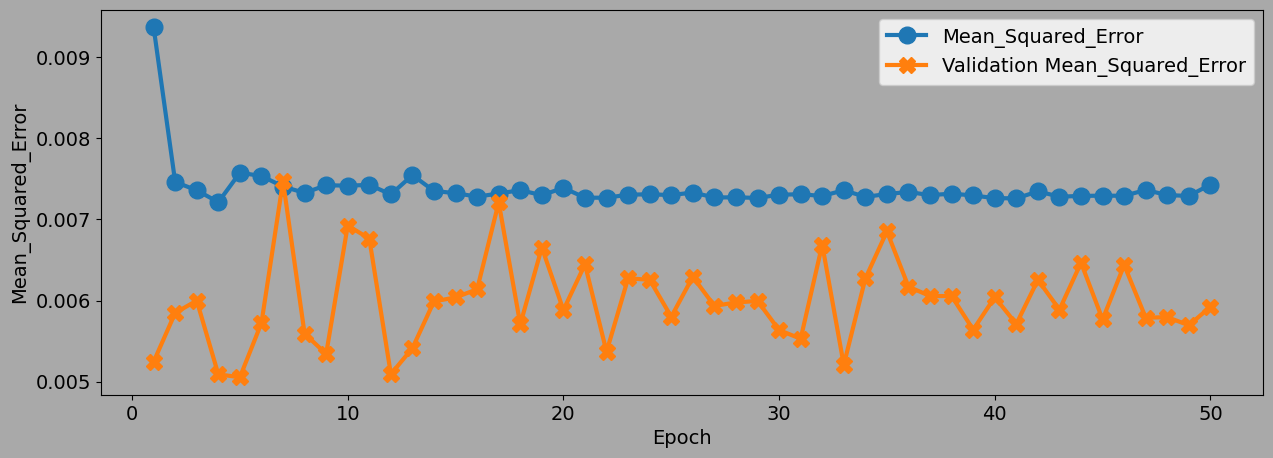

In [ ]:
plot_convergence(history_SimpleRNN, "mean_squared_error")

In [ ]:
history_SRNN = history_SimpleRNN.history

<Figure size 1500x500 with 0 Axes>

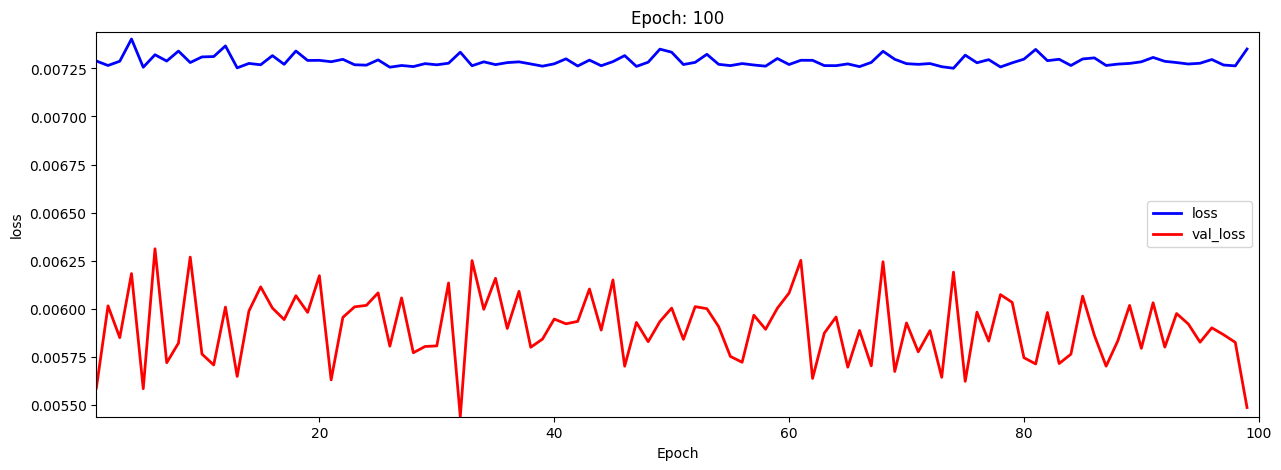

In [ ]:
grafico_animado(history_SRNN,funcao1= 'loss',funcao2="val_loss", mode='video')

<Figure size 1500x500 with 0 Axes>

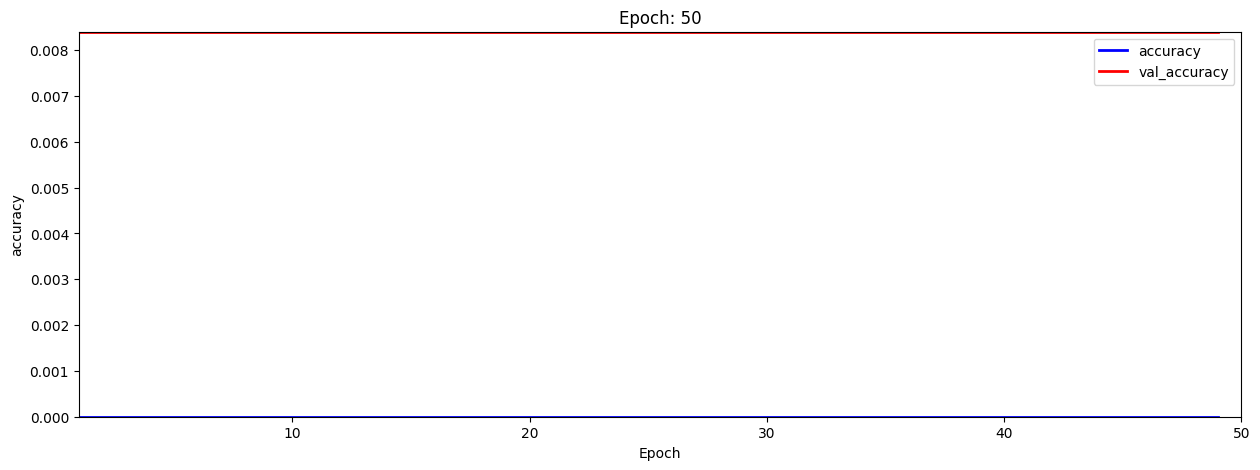

In [ ]:
grafico_animado(history_SRNN,funcao1= 'accuracy',funcao2="val_accuracy", mode='video')

## Fazendo as predições para os dados

In [ ]:
trainPredict = model_SimpleRNN.predict(X_train)
testPredict = model_SimpleRNN.predict(X_test)

9/9 [==============================] - 0s 5ms/step


In [32]:
X_test.shape

(284, 1, 15)

In [ ]:
testPredict

array([[[0.12354442]],

       [[0.12339275]],

       [[0.12337491]],

       [[0.12349857]],

       [[0.12343343]],

       [[0.12324117]],

       [[0.12326336]],

       [[0.12353763]],

       [[0.12328784]],

       [[0.12332046]],

       [[0.12366261]],

       [[0.12343125]],

       [[0.12321654]],

       [[0.12346774]],

       [[0.12342919]],

       [[0.12341398]],

       [[0.12328163]],

       [[0.12353224]],

       [[0.12338686]],

       [[0.12313609]],

       [[0.12328573]],

       [[0.12336713]],

       [[0.12323247]],

       [[0.12320405]],

       [[0.12341493]],

       [[0.12325345]],

       [[0.1231166 ]],

       [[0.12328392]],

       [[0.1234711 ]],

       [[0.12312075]],

       [[0.12328206]],

       [[0.12341021]],

       [[0.12313341]],

       [[0.12308206]],

       [[0.12327982]],

       [[0.12322736]],

       [[0.1231758 ]],

       [[0.12317103]],

       [[0.12323339]],

       [[0.12304847]],

       [[0.12289399]],

       [[0.12315

In [ ]:
testPredict.shape

(284, 1)

In [31]:
(X_train.shape[0], 1, X_train.shape[1])

(591, 1, 1)

In [ ]:
train_sc = trainPredict.shape
train_sc = train_sc[0:2]
train_sc

(591, 1)

In [ ]:
test_sc = testPredict.shape
test_sc = test_sc[0:2]
test_sc

(284, 1)

In [ ]:
trainPredict = model_SimpleRNN.predict(X_train)
testPredict = model_SimpleRNN.predict(X_test)

test_sc = testPredict.shape
test_sc = test_sc[0:2]
test_sc

train_sc = trainPredict.shape
train_sc = train_sc[0:2]
train_sc

trainPredict = np.reshape(trainPredict, (train_sc))
testPredict= np.reshape(testPredict, (test_sc))


trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([y_test])

trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

9/9 [==============================] - 0s 4ms/step
Train Score: 24566.40 RMSE
Test Score: 51689.45 RMSE


## Vendo a série prevista pela rede

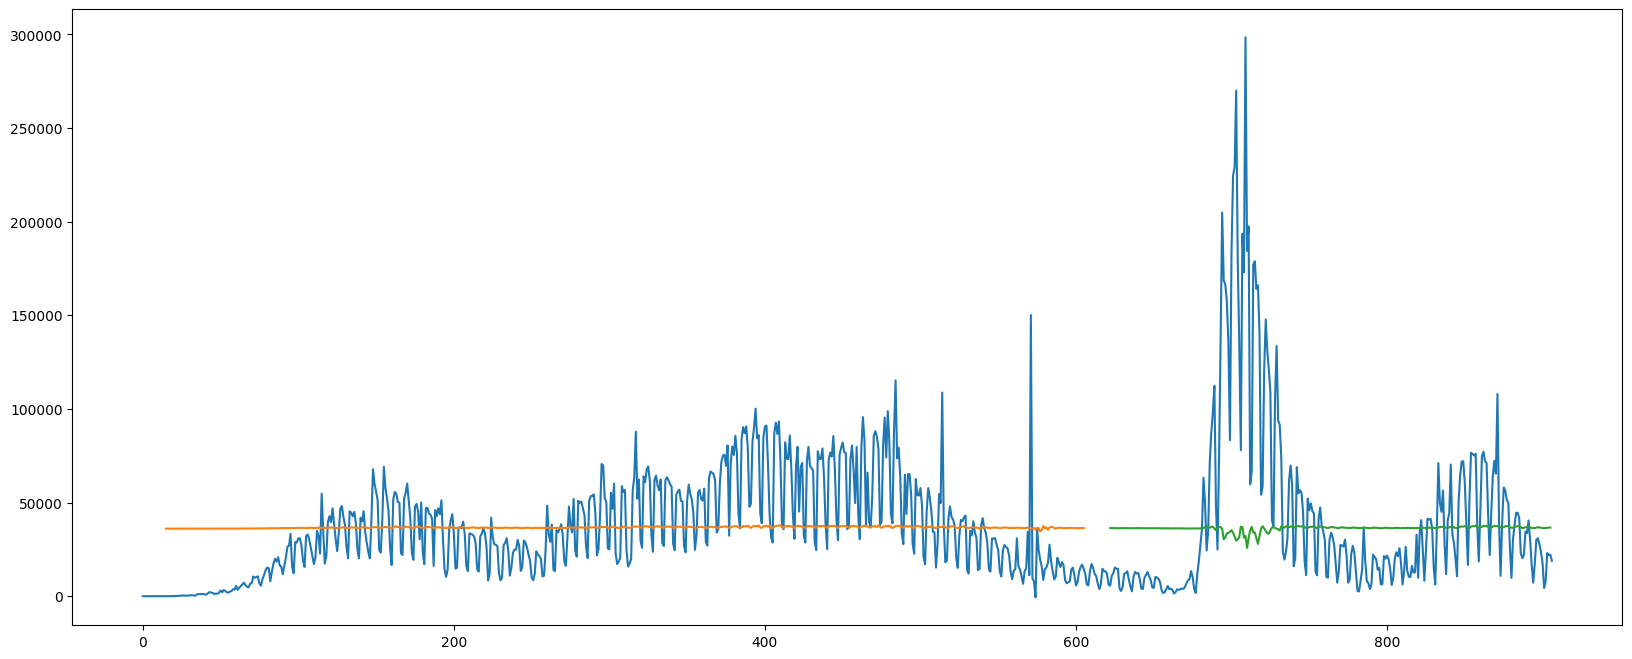

In [ ]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2) + 1 : len(dataset)-1, :] = testPredict

plt.figure(figsize=(20,8))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
model_SimpleRNN.save('covid_time_serie_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model_saved = keras.models.load_model('./covid_time_serie_model.h5')

# **Plotando as previsões**
A variável ```number_of_predictions``` é o número de previsões que serão feitas com o modelo treinado

In [ ]:
number_of_predictions=50
data = dataset[-look_back:]

In [ ]:
def generate_predicions(model,
                        dataset,
                        look_back,
                        number_of_predictions):
  data = dataset[-look_back:]
  predictions = []
  for i in range(number_of_predictions):
    prediction = model.predict(np.expand_dims(data.T, axis=0),
                               verbose=0)
    predictions.append([prediction[0][0]])
    data = np.append(data, prediction, axis=0)
    data = data[-look_back:]
  return predictions

In [ ]:
predictions = generate_predicions(model_SimpleRNN,
                                  dataset,
                                  look_back,
                                  number_of_predictions)

ValueError: ignored

In [ ]:
normal_dataset = scaler.inverse_transform(dataset)
normal_predictions = scaler.inverse_transform(predictions)

NameError: ignored

In [ ]:
predict_plot = np.empty_like(dataset)
predict_plot[:, :] = np.nan
predict_plot = np.append(predict_plot, normal_predictions)

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(predict_plot)
plt.show()